In [ ]:
%pip install pandas matplotlib seaborn openpyxl

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

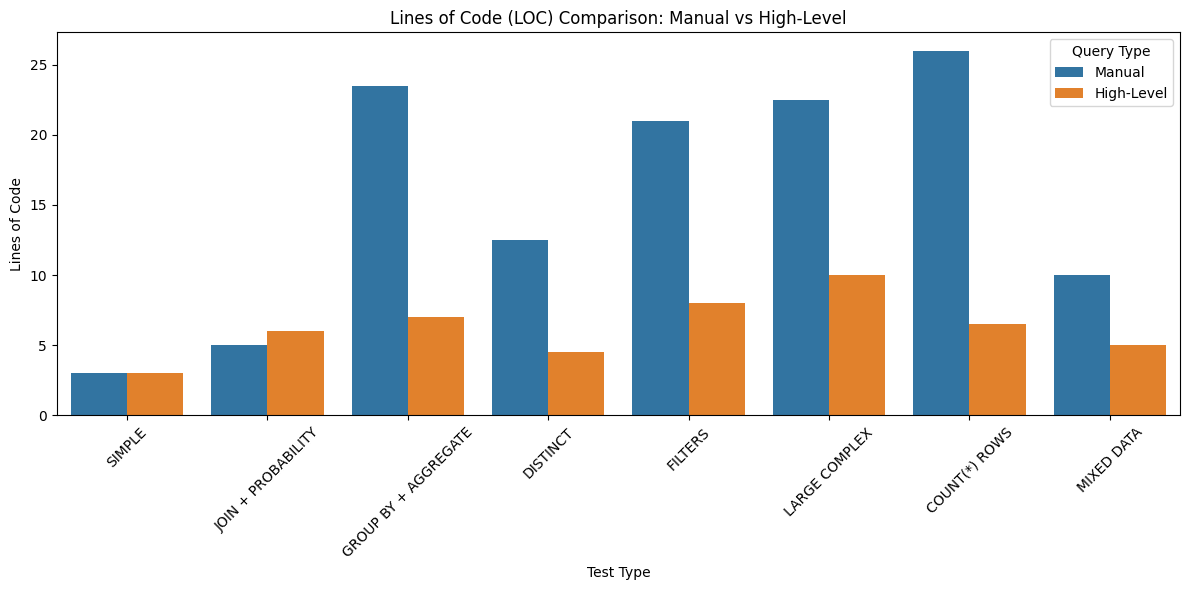

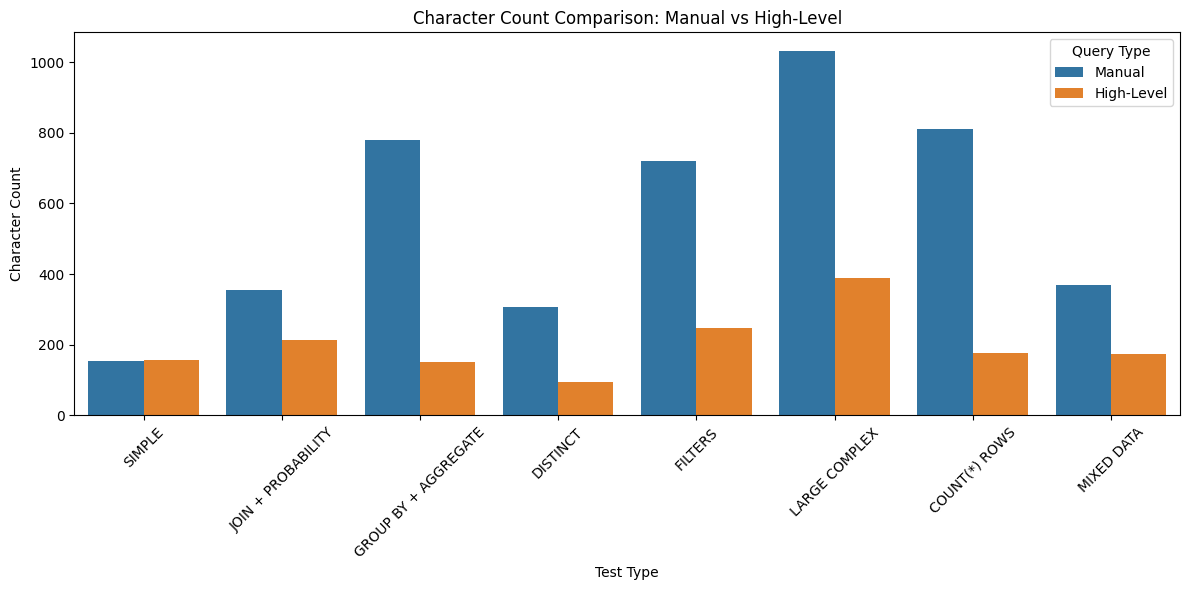

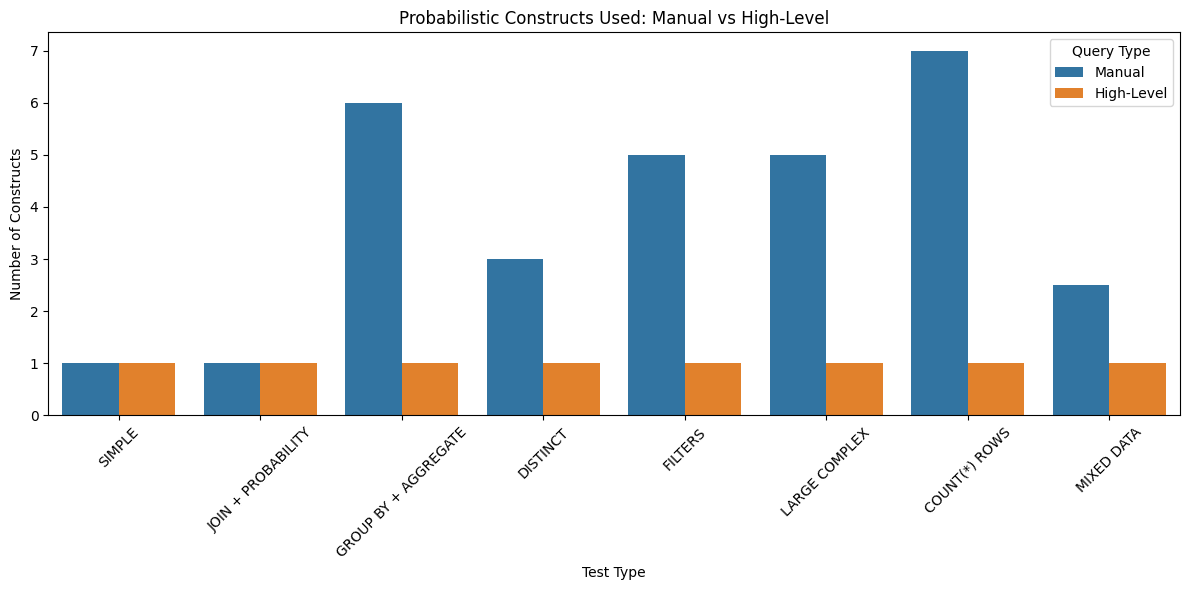

In [ ]:
df = pd.read_excel("ResultsManualVsHighLevel.xlsx")
df.columns = [col.strip() for col in df.columns]
df["Test Type"] = df["Test Type"].ffill()
df["Query Type"] = df["Test Query"].apply(lambda x: "Manual" if "Manual" in x else "High-Level")

# Plot 1: CL comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Test Type", y="Code Lines (CL)", hue="Query Type", errorbar=None)
plt.title("Code Lines (CL) Comparison: Manual vs High-Level")
plt.ylabel("Code Lines (CL)")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
plt.show()

# Plot 2: Character Count Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Test Type", y="Characters", hue="Query Type", errorbar=None)
plt.title("Character Count Comparison: Manual vs High-Level")
plt.ylabel("Character Count")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
plt.show()

# Plot 3: Level of Complexity (LoC) Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Test Type", y="Level of Complexity (LoC)", hue="Query Type", errorbar=None)
plt.title("Level of Complexity (LoC) Comparison: Manual vs High-Level")
plt.ylabel("Number of Constructs")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
plt.show()

# Prob Constructs are obvious


In [ ]:
manual_rows = df[df["Test Query"].str.contains("Manual")].copy().reset_index(drop=True)
high_rows = df[df["Query Type"].str.contains("High-Level")].copy().reset_index(drop=True)

# Construct the comparison DataFrame
comparison_df = pd.DataFrame()
comparison_df["Query Type"] = manual_rows["Test Type"]
comparison_df["Manual CL"] = manual_rows["Code Lines (CL)"]
comparison_df["High-Level CL"] = high_rows["Code Lines (CL)"]
comparison_df["Manual Characters"] = manual_rows["Characters"]
comparison_df["High-Level Characters"] = high_rows["Characters"]
comparison_df["Manual Complexity"] = manual_rows["Level of Complexity (LoC)"]
comparison_df["High-Level Complexity"] = high_rows["Level of Complexity (LoC)"]
comparison_df["Prob Constructs (Manual)"] = manual_rows["Probabilistic Constructs"]
comparison_df["Prob Constructs (High-Level)"] = high_rows["Probabilistic Constructs"]

# Group by Query Type and aggregate
grouped = comparison_df.groupby("Query Type").agg({
    "Manual CL": "mean",
    "High-Level CL": "mean",
    "Manual Characters": "mean",
    "High-Level Characters": "mean",
    "Manual Complexity": "mean",
    "High-Level Complexity": "mean",
    "Prob Constructs (Manual)": "sum",
    "Prob Constructs (High-Level)": "sum"
}).reset_index()

# Compute reductions
grouped["CL Reduction %"] = ((grouped["Manual CL"] - grouped["High-Level CL"]) / grouped["Manual CL"] * 100).round().astype("Int64").astype(str) + '%'
grouped["Char Reduction %"] = ((grouped["Manual Characters"] - grouped["High-Level Characters"]) / grouped["Manual Characters"] * 100).round().astype("Int64").astype(str) + '%'
grouped["Complexity Reduction %"] = ((grouped["Manual Complexity"] - grouped["High-Level Complexity"]) / grouped["Manual Complexity"] * 100).round().astype("Int64").astype(str) + '%'
grouped["Prob Constructs Reduction #"] = (grouped["Prob Constructs (Manual)"] - grouped["Prob Constructs (High-Level)"]).round().astype("Int64").astype(str)

# Compute overall reduction as a row
overall_row = {
    "Query Type": "Overall Reduction",
    "CL Reduction %": int(round((grouped["Manual CL"].sum() - grouped["High-Level CL"].sum()) / grouped["Manual CL"].sum() * 100)),
    "Char Reduction %": int(round((grouped["Manual Characters"].sum() - grouped["High-Level Characters"].sum()) / grouped["Manual Characters"].sum() * 100)),
    "Complexity Reduction %": int(round((grouped["Manual Complexity"].sum() - grouped["High-Level Complexity"].sum()) / grouped["Manual Complexity"].sum() * 100)),
    "Prob Constructs Reduction #": int(round((grouped["Prob Constructs (Manual)"].sum() - grouped["Prob Constructs (High-Level)"].sum()) / grouped["Prob Constructs (Manual)"].shape[0]))
}
overall_row["CL Reduction %"] = f"{overall_row['CL Reduction %']}%"
overall_row["Char Reduction %"] = f"{overall_row['Char Reduction %']}%"
overall_row["Complexity Reduction %"] = f"{overall_row['Complexity Reduction %']}%"
overall_row["Overall Reduction"] = str(overall_row["Prob Constructs Reduction #"])

grouped = pd.concat([grouped, pd.DataFrame([overall_row])], ignore_index=True)


# Reorder rows to match the original order: SIMPLE, JOIN + PROBABILITY, GROUP BY + AGGREGATE, DISTINCT, FILTERS, LARGE COMPLEX, COUNT(*) ROWS, MIXED DATA
order = [
    "SIMPLE",
    "JOIN + PROBABILITY",
    "GROUP BY + AGGREGATE",
    "DISTINCT",
    "FILTERS",
    "LARGE COMPLEX",
    "COUNT(*) ROWS",
    "MIXED DATA",
    "Overall Reduction"
]
grouped = grouped.set_index("Query Type").reindex(order).reset_index()

grouped_reduction = grouped[[
    "Query Type",
    "CL Reduction %", "Char Reduction %", "Complexity Reduction %",
    "Prob Constructs Reduction #"
]]

display(grouped_reduction)


,Query Type,CL Reduction %,Char Reduction %,Complexity Reduction %,Prob Constructs Reduction #
0,SIMPLE,0%,-2%,0%,0
1,JOIN + PROBABILITY,-20%,40%,0%,22
2,GROUP BY + AGGREGATE,70%,80%,83%,35
3,DISTINCT,64%,69%,67%,14
4,FILTERS,62%,66%,80%,25
5,LARGE COMPLEX,56%,62%,80%,36
6,COUNT(*) ROWS,75%,78%,86%,37
7,MIXED DATA,50%,53%,60%,11
8,Overall Reduction,60%,65%,74%,22
